In [4]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

training_dir = '/content/Data/training'
evaluate_dir = '/content/Data/evaluate'

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/data.zip', 'r')
zip_ref.extractall(evaluate_dir)
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/Utah_dup.zip', 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
#https://www.kaggle.com/code/hamzamanssor/surface-crack-detection-using-dl-models/notebook#Functions

from tqdm.notebook import tqdm

In [6]:
path = '/content/Data/training/Utah/'
path_all = list(glob.glob(path + '**/*.png', recursive=True))
path_Negative = path + 'U/*.png'
path_Positive = path + 'C/*.png'

In [7]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,/content/Data/training/Utah/U/026-69.png,U
1,/content/Data/training/Utah/U/7070-143.png,U
2,/content/Data/training/Utah/C/a7124-243.png,C
3,/content/Data/training/Utah/U/049-9.png,U
4,/content/Data/training/Utah/U/7114-41.png,U


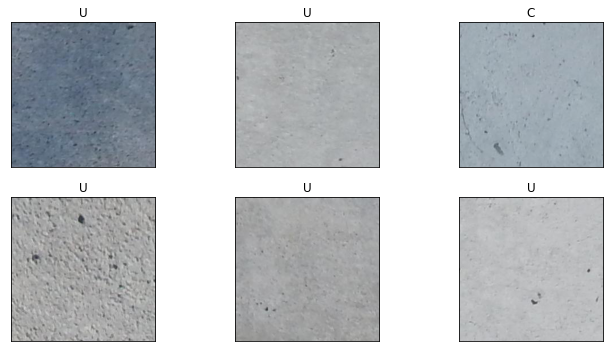

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i], 0))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [9]:
# Train and test split
train_df, test_df = train_test_split(data, test_size=0.2, stratify = data["Label"])

In [10]:
# Pre-processing for ALexNet

def gen(train,test):
    train_datagen = ImageDataGenerator(
                        rescale = 1./255,
                        validation_split = 0.2
                        )
    test_datagen = ImageDataGenerator(
                        rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [11]:
def func(name_model):
    pre_model = name_model(input_shape=(224,224, 3),
                   include_top=True,
                   weights='imagenet',
                   pooling='avg')
    # pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [12]:
def plot(history,df_test,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["Positive", "Negative"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1], 0))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [13]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# AlexNet

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

train_gen_AlexNet, valid_gen_AlexNet, test_gen_AlexNet = gen(train_df,test_df)

Found 51660 validated image filenames belonging to 2 classes.
Found 51660 validated image filenames belonging to 2 classes.
Found 12916 validated image filenames belonging to 2 classes.


In [15]:
model_alex_net = tf.keras.models.Sequential([
     # 1st conv layer                                        
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3),
                           padding='valid'),
    tf.keras.layers.BatchNormalization(),
    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),

    # 2nd conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),

    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    # 3rd conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 4th Conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 5th Conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # Max Pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
model_alex_net.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_15 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                      

In [16]:
model_alex_net.compile(loss='categorical_crossentropy', optimizer ="Adam", metrics=['accuracy'])

In [17]:
# This is our callback function
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]

In [18]:
hist = model_alex_net.fit(
    train_gen_AlexNet,
    validation_data = valid_gen_AlexNet,
    epochs = 100,
    callbacks=my_callbacks
)

Epoch 1/100
808/808 [==============================] - 265s 313ms/step - loss: 0.7412 - accuracy: 0.7047 - val_loss: 0.7741 - val_accuracy: 0.7371
Epoch 2/100
808/808 [==============================] - 223s 277ms/step - loss: 0.6730 - accuracy: 0.7311 - val_loss: 0.6019 - val_accuracy: 0.7306
Epoch 3/100
808/808 [==============================] - 218s 270ms/step - loss: 0.6686 - accuracy: 0.7380 - val_loss: 0.6351 - val_accuracy: 0.7346


              precision    recall  f1-score   support

    Positive       0.49      0.20      0.28      3394
    Negative       0.76      0.93      0.84      9522

    accuracy                           0.74     12916
   macro avg       0.63      0.56      0.56     12916
weighted avg       0.69      0.74      0.69     12916



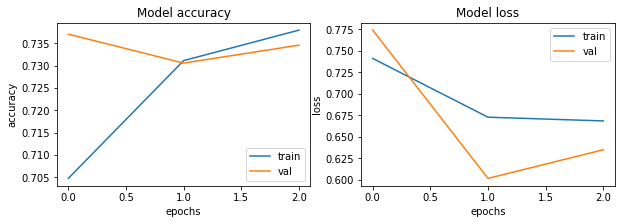

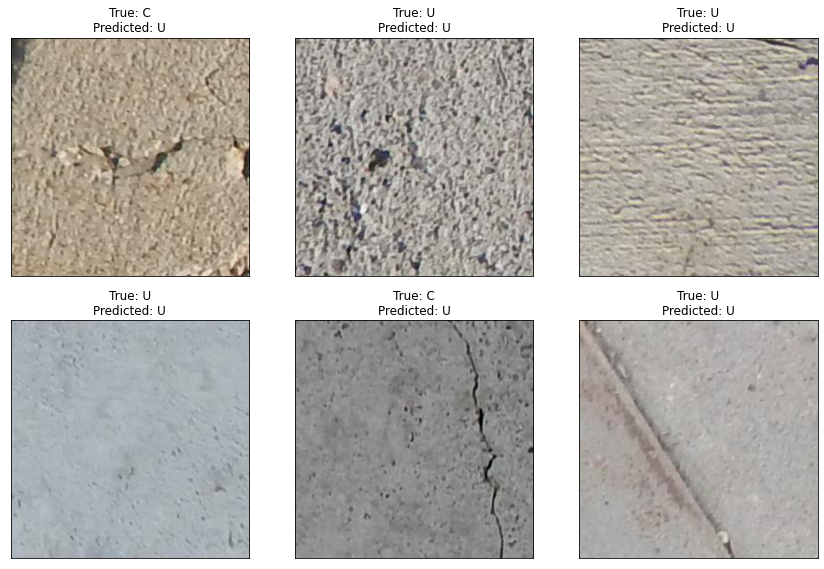

In [19]:
history=plot(hist,test_df,test_gen_AlexNet,train_gen_AlexNet,model_alex_net)

In [20]:
result = result_test(test_gen_AlexNet,model_alex_net)

    Test Loss: 0.62881
Test Accuracy: 73.61%


In [ ]:
result

[0.7537640929222107, 0.5696036219596863]

In [24]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name = 'Label', index = filepaths.index)
    df = pd.concat([filepaths, labels], axis = 1)
    return df

from pathlib import Path

# Set to the respective directory category of unseen data
positive_Images_dir = Path("/content/Data/evaluate/data/images/Positive")
negative_Images_dir = Path("/content/Data/evaluate/data/images/Negative")

# create positive and negative df
positive_Images_df = generate_df(positive_Images_dir, label = "POSITIVE")
negative_Images_df = generate_df(negative_Images_dir, label = "NEGATIVE")


In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
import numpy as np

# Create boolean function
def label_generator(index):
    if index == 0:
        return "POSITIVE"
    else:
        return "NEGATIVE"

# Create getter function 
# Inputs are your image directories and the CNN model
def single_prediction_generator(image_dir,model):
    img_path = image_dir
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    # Return the confidence interval for image
    prediction = model.predict(img_preprocessed)
    index = np.argmax(prediction[0])
    label = label_generator(index)
    
    # Return index
    return label

# return an array of the predicted labels
def prediction_array_generator(category_df,model):
    predicted_label = []
    
    # Iterate through the dataframe
    for image_dir in category_df['Filepath']:
        temp = single_prediction_generator(image_dir,model)
        predicted_label.append(temp)        
    
    # Return the list of the prediction label
    return predicted_label


In [26]:
positive_pred_label = prediction_array_generator(positive_Images_df, model_alex_net)
negative_pred_label = prediction_array_generator(negative_Images_df, model_alex_net)


In [27]:
positive_pred_label.count("POSITIVE")

19265

In [28]:
negative_pred_label.count("NEGATIVE")

332

In [ ]:
img_path = "/content/Data/evaluate/images/Negative/01693.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = ResNet50_model.predict(img_preprocessed)
prediction

In [ ]:
print(metrics.confusion_matrix(y_act, y_pred, labels=["a", "b", "c"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=["a", 
"b","c"]))

In [ ]:
# Insert the prediction columns into the dataframe

positive_Images_df.insert(2,"AlexNet",positive_pred_label)
negative_Images_df.insert(2,"AlexNet",negative_pred_label)

In [ ]:
negative_Images_df

In [ ]:
positive_Images_df

In [ ]:
# Define true_positive
# return a list
# must positive quanity to be taken in
def true_positive(category_df):
    count_AlexNet = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["AlexNet"][i]:
            count_AlexNet += 1
            
    return count_AlexNet

# Define false negative
def false_negative(tp_models,category_df):
    fn_models = []
    fn_vgg = len(category_df) - tp_models[0]
    fn_resnet50 = len(category_df) - tp_models[1]
    fn_models.append(fn_vgg)
    fn_models.append(resnet50)
    return fp_models

    

In [ ]:
def true_negative(category_df):
    count_AlexNet = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["AlexNet"][i]:
            count_AlexNet += 1
    return count_AlexNet
def false_positive(tn_models,category_df):
    fp_models = []
    fp_vgg = 1 - tn_models[0]
    fp_resnet = 1 - tn_models[1]
    fp_models.append(fp_vgg)
    fp_models.append(fp_resnet)
    return fp_models

# Alexnet Prediction for Blur

In [35]:
positive_Images_dir2 = Path("/content/Data/evaluate/data/blur/Positive")
negative_Images_dir2 = Path("/content/Data/evaluate/data/blur/Negative")

In [36]:
# create positive and negative df
positive_Images_df2 = generate_df(positive_Images_dir2, label = "POSITIVE")
negative_Images_df2 = generate_df(negative_Images_dir2, label = "NEGATIVE")

In [38]:
positive_pred_label2 = prediction_array_generator(positive_Images_df2,model_alex_net)
negative_pred_label2 = prediction_array_generator(negative_Images_df2,model_alex_net)

In [39]:
positive_pred_label2.count("POSITIVE")

19318

In [40]:
negative_pred_label2.count("NEGATIVE")

304

In [ ]:
positive_Images_df2.insert(2,"AlexNet",positive_pred_label2)
negative_Images_df2.insert(2,"AlexNet",negative_pred_label2)

In [ ]:
stat3 = true_positive(positive_Images_df2)
stat3

In [ ]:
stat4 = true_negative(negative_Images_df2)
stat4

# AlexNet Prediction for Bright

In [29]:
positive_Images_dir3 = Path("/content/Data/evaluate/data/bright/Positive")
negative_Images_dir3 = Path("/content/Data/evaluate/data/bright/Negative")

In [31]:
# create positive and negative df
positive_Images_df3 = generate_df(positive_Images_dir3, label = "POSITIVE")
negative_Images_df3 = generate_df(negative_Images_dir3, label = "NEGATIVE")

In [32]:
positive_pred_label3 = prediction_array_generator(positive_Images_df3,model_alex_net)
negative_pred_label3 = prediction_array_generator(negative_Images_df3,model_alex_net)

In [33]:
positive_pred_label3.count("POSITIVE")

18900

In [34]:
negative_pred_label3.count("NEGATIVE")

545

In [ ]:
positive_Images_df3.insert(2,"AlexNet",positive_pred_label3)
negative_Images_df3.insert(2,"AlexNet",negative_pred_label3)

In [ ]:
stat5 = true_positive(positive_Images_df3)
stat5

In [ ]:
stat6 = true_negative(negative_Images_df3)
stat6